In [26]:
# gms = s.get_games_season(2024)

# Last run on 3/21

In [27]:
# gms[0].to_csv('NCAAteams.csv', index=False)
# gms[1].to_csv('NCAAplyrs.csv', index=False)
# gms[2].to_csv('NCAApbp.csv', index=False)

In [101]:
# !pip install cbbpy
import cbbpy.mens_scraper as s

In [103]:
aug = s.get_games_range("2024-03-22", "2024-03-23")

  0%|          | 0 of 3 days scraped in 0.0 sec

Scraping 15 games on 03/23/24: 100%|██████████| 3 of 3 days scraped in 29.6 sec


In [110]:
teamAug = aug[0]
plyrAug = aug[1]
pbpAug = aug[2]

In [115]:
teamAug[teamAug.game_day == teamAug.game_day[0]].shape

(16, 27)

In [116]:
team_df[team_df.game_day == teamAug.game_day[0]].shape

(8, 27)

In [28]:
from scipy import stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
pd.options.mode.copy_on_write = True

In [29]:
team_df = pd.read_csv('NCAAteams.csv')
plyr_df = pd.read_csv('NCAAplyrs.csv')
# df2 = pd.read_csv('NCAApbp.csv')

In [30]:
team_df.columns

Index(['game_id', 'home_team', 'home_id', 'home_rank', 'home_record',
       'home_score', 'away_team', 'away_id', 'away_rank', 'away_record',
       'away_score', 'home_win', 'num_ots', 'is_conference', 'is_neutral',
       'is_postseason', 'tournament', 'game_day', 'game_time', 'game_loc',
       'arena', 'arena_capacity', 'attendance', 'tv_network', 'referee_1',
       'referee_2', 'referee_3'],
      dtype='object')

In [31]:
plyr_df.columns

Index(['game_id', 'team', 'player', 'player_id', 'position', 'starter', 'min',
       'fgm', 'fga', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'to', 'pf', 'pts'],
      dtype='object')

In [32]:
plyrs = plyr_df.player.unique()

teams = pd.concat([team_df.home_team,team_df.away_team], axis=0).unique()

Make below more efficient

In [34]:
def addOpp(x):
    id = x.game_id
    gm = team_df[team_df.game_id == id]
    if gm.home_team.values[0] == x.team:
        return gm.away_team.values[0]
    else:
        return gm.home_team.values[0]

# Todo :: add functionality and rename
def PtAdds(df, nm):
    df["Home/Away"] = np.where(df.home_team == nm, "Home", "Away")
    df["PtsFor"] = np.where(df.home_team == nm, df.home_score, df.away_score)
    df["PtsAgainst"] = np.where(df.home_team == nm, df.away_score, df.home_score)
    df["TotalPts"] = df.PtsFor + df.PtsAgainst
    df["Opp"] = addOpp(df)
    return df

def tm_search(s):
    lst = np.array([x for x in teams if s in x])
    return lst

def get_team_games(team):
    tm = team_df[np.logical_or(team_df.home_team == team, team_df.away_team == team)]
    plyr = plyr_df[plyr_df.team == team]
    tm = PtAdds(tm, team)
    tm["Spread"] = tm.PtsFor - tm.PtsAgainst
    tm["Win"] = np.where(tm.PtsFor > tm.PtsAgainst, True, False)
    return {"team":tm, "players":plyr}

def prop_hit(col, prop, df):
    return np.where(df[col] > prop, True, False)

def prop_build(col, prop, df):
    return np.where(df[col] > prop, df[col] - prop, prop - df[col])

In [36]:
# make a method to replace the below cell of getting all the teams for a given days games
# parameter should be a list of tuples [(tm1, tm2),,,]
def create_game_data(team_tuples):
    game_data = []
    
    for tm1, tm2 in team_tuples:
        game_dict = {}
        
        nm1 = tm_search(tm1)
        nm2 = tm_search(tm2)
        if len(nm1) > 1:
            print(f"Non-unique id {tm1}, returning {nm1[0]}")
        if len(nm2) > 1:
            print(f"Non-unique id {tm2}, returning {nm2[0]}")
        tm1 = nm1[0]
        tm2 = nm2[0]

        game_dict[tm1] = get_team_games(tm1)
        game_dict[tm2] = get_team_games(tm2)
        
        game_data.append(game_dict)

    return game_data



In [53]:
from matplotlib import pyplot as plt
def regression(df, x, y):
    if not x in df.columns or not y in df.columns:
        msg = "Neither Column in DataFrame" if not x in df.columns and not y in df.columns else\
                                            (f"{x} not in DataFrame" if not x in df.columns else
                                             f"{y} not in DataFrame")
        print(msg)
        return None
    
    fit = np.linalg.lstsq(np.vstack([df[x], np.ones(len(df[x]))]).T, df[y], rcond=None)
    return fit

def regress_prop(df, x, y, prop, k=0, build=True, prefix=None, show=False, loc=None, save=False):
    fit = regression(df, x, y)

    # prop build is a series of scalars, prop hit is a series of booleans
    pline = prop_build(prop, k, df) if build else prop_hit(prop, k, df)
    if show:
        fig, ax = plt.subplots()
        ax.plot(df[x], fit[0][0]*df[x] + fit[0][1], color='Black', label="Regression Line")
        ax.plot(df[x], [df[y].mean()]*len(df[x]), color='Blue', label=f"{y} Mean")
        ax.plot([df[x].mean()]*len(df[y]), df[y], color='Orange', label=f"{x} Mean")

        # if prop line is a series of booleans, color by True/False
        # if prop line is a series of scalars, adjust size by scalar value and color by sign
        if build:
            psize = 1 + abs(pline)
            ax.scatter(df[x], df[y], s=psize, color=np.where(pline > k, 'Green', 'Red'))
        else:
            ax.scatter(df[x], df[y], color=np.where(pline==True, 'Green', 'Red'))
            
        fname = f'{y}_vs_{x}_with_{prop}_regression.png'
        if prefix != None:
            fname = prefix + "_" + fname
            ax.set_title(f'{prefix} {y} vs {x}; {prop} > {k}')
            ax.legend()
        if loc != None:
            fname = loc + "/" +fname
        if save:
            fig.savefig(fname)
        plt.show()
    return fit


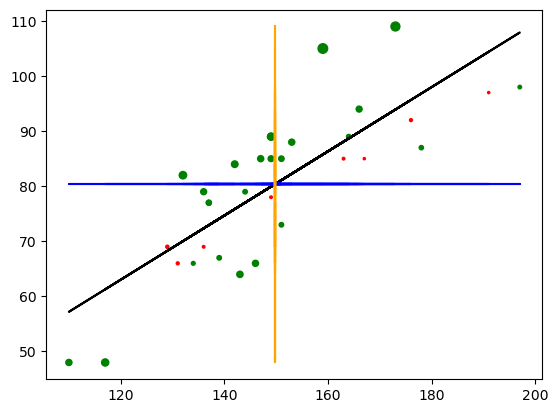

(array([ 0.58288647, -6.92041189]),
 array([2219.69373565]),
 2,
 array([8.67763490e+02, 7.24583432e-01]))

In [54]:
regress_prop(Jays["team"], "TotalPts", "PtsFor", "Spread", k=4.5, build=True, show=True, save=False)

In [13]:
tm_search("Creighton")

array(['Creighton Bluejays'], dtype='<U18')

In [37]:
# March 23
mar23 = []
# Gm1 : 12:45 PM
Dayton = get_team_games(tm_search("Dayton")[0])
Arizona = get_team_games(tm_search("Arizona Wildcats")[0])
gm1 = {"Dayton":Dayton, "Arizona":Arizona}
mar23.append(gm1)
# Gm2 : 3:15 PM
Gonzaga = get_team_games(tm_search("Gonzaga")[0])
Kansas = get_team_games(tm_search("Jayhawks")[0])
gm2 = {"Gonzaga":Gonzaga, "Kansas":Kansas}
mar23.append(gm2)
# Gm3 : 5:30 PM
Sparty = get_team_games(tm_search("Michigan State")[0])
Tarheels = get_team_games(tm_search("Tar Heels")[0])
gm3 = {"Michigan State":Sparty, "North Carolina":Tarheels}
mar23.append(gm3)
# Gm4 : 6:10 PM
Cyclones = get_team_games(tm_search("Iowa State")[0])
Cougars = get_team_games(tm_search("Washington State")[0])
gm4 = {"Iowa State":Cyclones, "Washington State":Cougars}
mar23.append(gm4)
# Gm5 : 7:10 PM
Wolfpack = get_team_games(tm_search("NC State")[0])
Oakland = get_team_games(tm_search("Oakland Golden")[0])
gm5 = {"NC State":Wolfpack, "Oakland":Oakland}
mar23.append(gm5)
# Gm6 : 8:00 PM
Longhorns = get_team_games(tm_search("Texas Longhorns")[0])
Volunteers = get_team_games(tm_search("Tennessee Volunteers")[0])
gm6 = {"Texas":Longhorns, "Tennessee":Volunteers}
mar23.append(gm6)
# Gm7 : 8:40 PM
Dukes = get_team_games(tm_search("Duquesne")[0])
Illni = get_team_games(tm_search("Illinois Fighting")[0])
gm7 = {"Duquesne":Dukes, "Illinois":Illni}
mar23.append(gm7)
# Gm8 : 9:40 PM
Ducks = get_team_games(tm_search("Oregon Ducks")[0])
Jays = get_team_games(tm_search("Creighton")[0])
gm8 = {"Oregon":Ducks, "Creighton":Jays}
mar23.append(gm8)

# Make a list of tuples where each tuple is the teams in a game above
mar23_teams = [("Dayton", "Arizona Wildcats"), ("Gonzaga", "Jayhawks"), ("Michigan State", "Tar Heels"), 
               ("Iowa State", "Washington State"), ("NC State", "Oakland Golden"), ("Texas Longhorns", "Tennessee Volunteers"),
               ("Duquesne", "Illinois Fighting"), ("Oregon Ducks", "Creighton")]

tst = create_game_data(mar23_teams)


In [38]:

tm_names = []
[tm_names.append(x.keys()) for x in tst]

[None, None, None, None, None, None, None, None]

In [45]:
Jays['team'].columns

Index(['game_id', 'home_team', 'home_id', 'home_rank', 'home_record',
       'home_score', 'away_team', 'away_id', 'away_rank', 'away_record',
       'away_score', 'home_win', 'num_ots', 'is_conference', 'is_neutral',
       'is_postseason', 'tournament', 'game_day', 'game_time', 'game_loc',
       'arena', 'arena_capacity', 'attendance', 'tv_network', 'referee_1',
       'referee_2', 'referee_3', 'Home/Away', 'PtsFor', 'PtsAgainst',
       'TotalPts', 'Spread', 'Win'],
      dtype='object')

In [39]:
tm_names

[dict_keys(['Dayton Flyers', 'Arizona Wildcats']),
 dict_keys(['Gonzaga Bulldogs', 'Kansas Jayhawks']),
 dict_keys(['Michigan State Spartans', 'North Carolina Tar Heels']),
 dict_keys(['Iowa State Cyclones', 'Washington State Cougars']),
 dict_keys(['NC State Wolfpack', 'Oakland Golden Grizzlies']),
 dict_keys(['Texas Longhorns', 'Tennessee Volunteers']),
 dict_keys(['Duquesne Dukes', 'Illinois Fighting Illini']),
 dict_keys(['Oregon Ducks', 'Creighton Bluejays'])]

In [20]:
np.where(Illni["team"].Spread > 10.5, False, True).sum()/len(Illni["team"])

0.5142857142857142

In [57]:
sprd = {"Dayton Flyers":9.5,
        "Gonzaga Bulldogs":-4.5,
        "Michigan State Spartans":2.5,
        "Iowa State Cyclones":-6.5,
        "NC State Wolfpack":-6.5,
        "Texas Longhorns":6.5,
        "Duquesne Dukes":10.5,
        "Oregon Ducks":4.5
        }

In [23]:
Kansas["players"].columns

Index(['game_id', 'team', 'player', 'player_id', 'position', 'starter', 'min',
       'fgm', 'fga', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'to', 'pf', 'pts', 'Opp'],
      dtype='object')

In [131]:
Dayton["team"].PtsFor.quantile(.25)

65.75

In [75]:
Jays["team"].map(lambda x : type(x))

,game_id,home_team,home_id,home_rank,home_record,home_score,away_team,away_id,away_rank,away_record,...,tv_network,referee_1,referee_2,referee_3,Home/Away,PtsFor,PtsAgainst,TotalPts,Spread,Win
184,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,...,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'bool'>
373,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,...,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'bool'>
507,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,...,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'bool'>
745,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,...,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'bool'>
978,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,...,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'bool'>
1047,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,...,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'bool'>
1390,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,...,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'bool'>
1545,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,...,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'bool'>
1750,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,...,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'bool'>
1947,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,...,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'bool'>


In [83]:
jdf = Jays["team"]

In [84]:
jdf["OppRank"] = Jays["team"].apply((lambda x: x["home_rank"] if x["Home/Away"] == "Away" else x["away_rank"]), axis=1)

In [88]:
JaysRkdOpps = jdf["OppRank"].dropna()

In [93]:
jdf_subset = jdf.loc[JaysRkdOpps.index]

In [96]:
subset_jdf = jdf[~jdf.index.isin(JaysRkdOpps.index)]

In [85]:
jdf["OppRank"].isna().sum()/len(jdf["OppRank"])

0.8181818181818182

In [98]:
subset_jdf[["PtsFor", "PtsAgainst", "TotalPts", "Spread"]].describe()

,PtsFor,PtsAgainst,TotalPts,Spread
count,27.000000,27.000000,27.000000,27.000000
mean,82.185185,70.222222,152.407407,11.962963
std,13.499393,12.410707,18.909215,17.747116
min,48.000000,50.000000,117.000000,-21.000000
25%,75.000000,61.000000,139.500000,0.000000
50%,85.000000,67.000000,149.000000,8.000000
75%,89.000000,78.500000,164.500000,23.000000
max,109.000000,99.000000,197.000000,51.000000


In [99]:
jdf_subset[["PtsFor", "PtsAgainst", "TotalPts", "Spread"]].describe()

,PtsFor,PtsAgainst,TotalPts,Spread
count,6.000000,6.000000,6.000000,6.000000
mean,72.500000,65.833333,138.333333,6.666667
std,14.774979,6.400521,18.500450,13.276546
min,48.000000,60.000000,110.000000,-14.000000
25%,67.500000,60.500000,131.000000,-1.500000
50%,73.000000,64.000000,138.000000,11.500000
75%,83.000000,70.500000,148.000000,16.250000
max,89.000000,75.000000,164.000000,19.000000


In [60]:
Jays["team"][["TotalPts", "PtsFor", "PtsAgainst"]].describe()

,TotalPts,PtsFor,PtsAgainst
count,33.000000,33.000000,33.000000
mean,149.848485,80.424242,69.424242
std,19.348968,14.020142,11.597495
min,110.000000,48.000000,50.000000
25%,137.000000,69.000000,60.000000
50%,149.000000,84.000000,66.000000
75%,163.000000,89.000000,78.000000
max,197.000000,109.000000,99.000000


In [59]:
Ducks["team"][["TotalPts", "PtsFor", "PtsAgainst"]].describe()

,TotalPts,PtsFor,PtsAgainst
count,35.000000,35.000000,35.000000
mean,147.542857,75.657143,71.885714
std,18.625319,9.219362,12.316348
min,118.000000,56.000000,49.000000
25%,133.500000,67.500000,63.500000
50%,149.000000,77.000000,71.000000
75%,158.000000,82.000000,80.000000
max,190.000000,92.000000,103.000000


In [ ]:
# Make Directory for Regression Plots
os.makedirs("PtsRegressions", exist_ok=True)
os.makedirs("Residuals", exist_ok=True)


# Messy but no big deal
for d in tst:
    keys = d.keys()
    l = len(keys)
    rfig, raxes = plt.subplots(1, l, figsize=(15, 7.5))
    sfig, saxes = plt.subplots(1, l, figsize=(15, 7.5))
    spread = 0
    rminfor = min([d[k]["team"].PtsFor.min() for k in keys])
    rmaxfor = max([d[k]["team"].PtsFor.max() for k in keys])
    rmintot = min([d[k]["team"].TotalPts.min() for k in keys])
    rmaxtot = max([d[k]["team"].TotalPts.max() for k in keys])
    rminfor = int(rminfor/10)*10
    rmintot = int(rmintot/10)*10
    rmaxfor = int(rmaxfor/10)*10
    rmaxtot = int(rmaxtot/10)*10
    ry_ticks = np.arange(rmintot, rmaxtot+10, 10)
    rx_ticks = np.arange(rminfor, rmaxfor+10, 10)

    # identify spread direction
    for k in keys:
        if k in sprd.keys():
            spread = (k, sprd[k])
    smin = None
    smax = None

    # Generate Plots for each team
    for i, (k, v) in enumerate(d.items()):
        # Generate Least Squares Linear Fit
        df = v["team"]
        fit = regress_prop(df, x="PtsFor", y="TotalPts",
                            prop="Spread", k=spread[1], build=True, show=False, prefix=k) if spread[0] == k else \
                    regress_prop(df, "PtsFor", "TotalPts", "Spread", -1*spread[1], prefix=k) # defaults for build & show are same as above
        # Generate Regression Plots
        ln = [fit[0][0]*x + fit[0][1] for x in [rminfor, rmaxfor]]
        raxes[i].plot([rminfor, rmaxfor], ln, color='Black', label="Regression Line")
        raxes[i].plot(df["PtsFor"], [df["TotalPts"].mean()]*len(df["PtsFor"]), color='Blue', label="TotalPts Mean")
        raxes[i].plot([df["PtsFor"].mean()]*len(df["TotalPts"]), df["TotalPts"], color='Orange', label="PtsFor Mean")
        raxes[i].scatter(df["PtsFor"], df["TotalPts"], color=np.where(df["Spread"] > -1*spread[1], "Green", "Red"))
        raxes[i].set_xticks(rx_ticks)
        raxes[i].set_yticks(ry_ticks)
        s = spread[1] if spread[0] == k else -1*spread[1]
        raxes[i].set_title(f'{k}; spread of {s}')

        # Generate Residuals Plots
        residuals = df["TotalPts"] - (fit[0][0]*df["PtsFor"] + fit[0][1])
        saxes[i].scatter(df["PtsFor"], residuals, color=np.where(df["Spread"] > -1*spread[1], "Green", "Red"))
        saxes[i].set_xticks(rx_ticks)
        saxes[i].set_title(f'{k} Residuals')
        saxes[i].plot([rminfor, rmaxfor], residuals.mean()*np.ones(2), color='Black', label="Residual Mean")
        # annotate the saxes[i] with residuals mean, 25th pct, 75th pct, and std
        coords = (-0.25, 0.95) if i == 0 else (1.05, 0.95)
        saxes[i].annotate(f"Sum: {'{0:.2g}'.format(fit[1][0])}\n25th pct: {'{0:.0g}'.format(residuals.quantile(.25))}\n75th pct: {'{0:.0g}'.format(residuals.quantile(.75))}\nstd: {int(residuals.std())}", xy=coords, 
                          xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle="round", fc="w"))
        
        if smin == None:
            smin = residuals.min()
            smax = residuals.max()
        else:
            smin = min(smin, residuals.min())
            smax = max(smax, residuals.max())
    saxes[0].set_yticks(np.arange(smin-5, smax+5, 5))
    saxes[1].set_yticks(np.arange(smin-5, smax+5, 5))
    sfig.suptitle("Residuals of Pts Total vs Pts For")
    rfig.suptitle("Total Points vs Points For")
    raxes[0].legend()
    tms = "_".join(keys)
    fname =f'{tms}_TotalPts_vs_PtsFor_with_{k}_spread_regression.png'
    rfig.savefig(f"PtsRegressions/{fname}")
    fname =f'{tms}_Residuals_with_{k}_spread.png'
    sfig.savefig(f"Residuals/{fname}")

In [166]:
pd.to_datetime(Arizona["team"].game_day).map(lambda x: x.month).unique()

array([11, 12,  1,  2,  3])

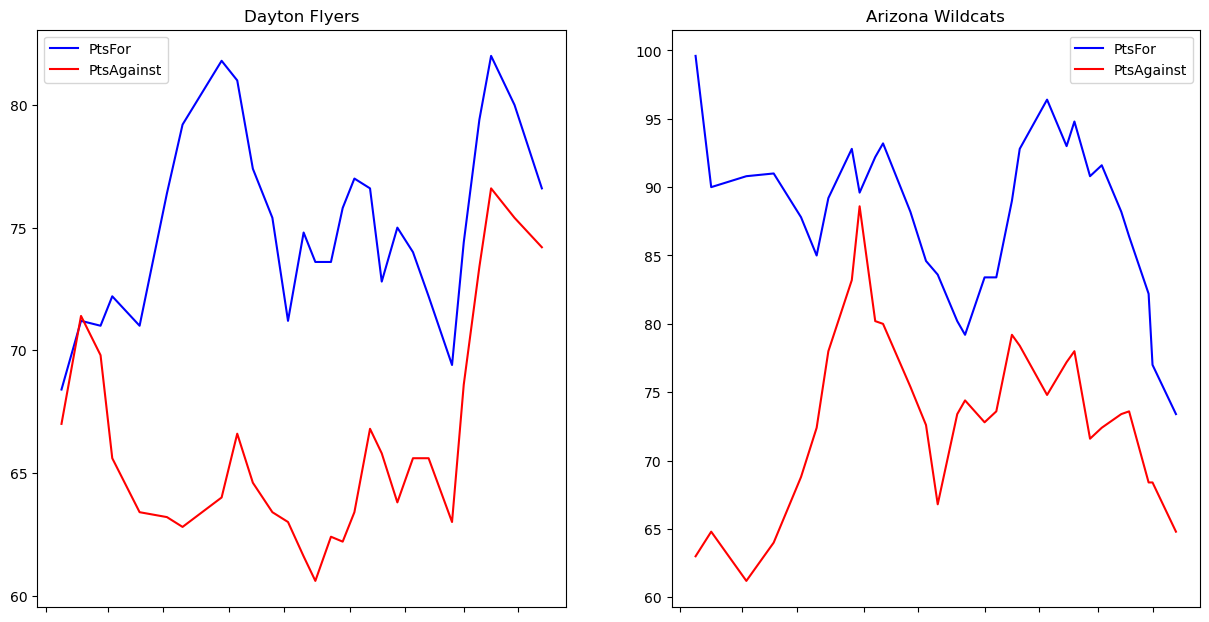

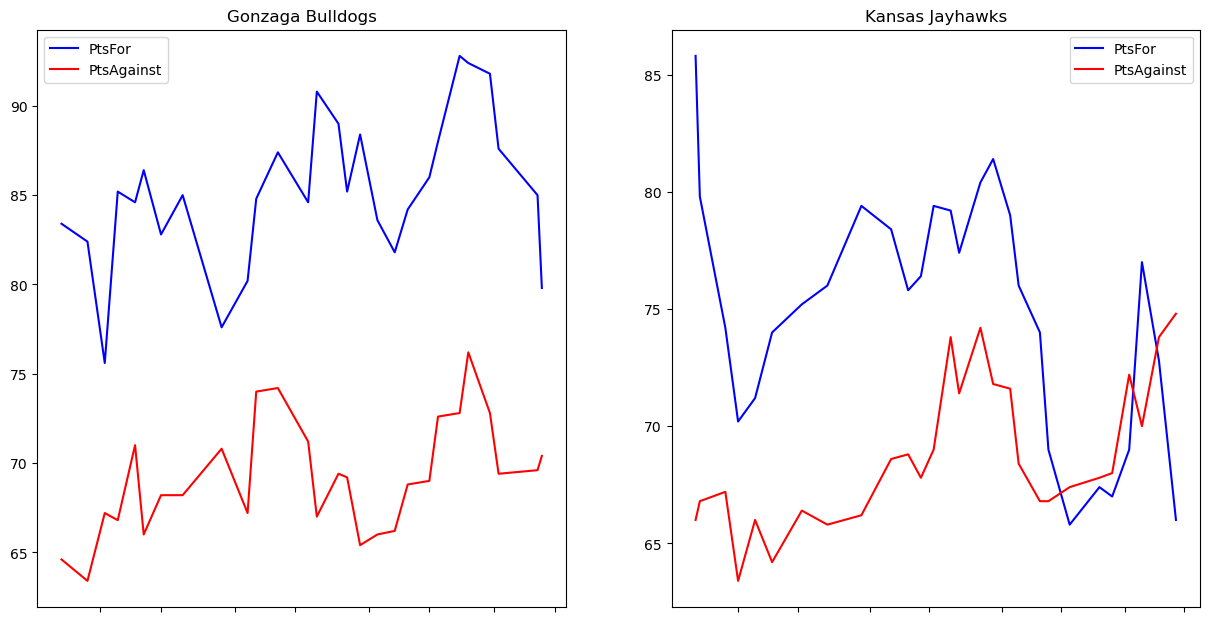

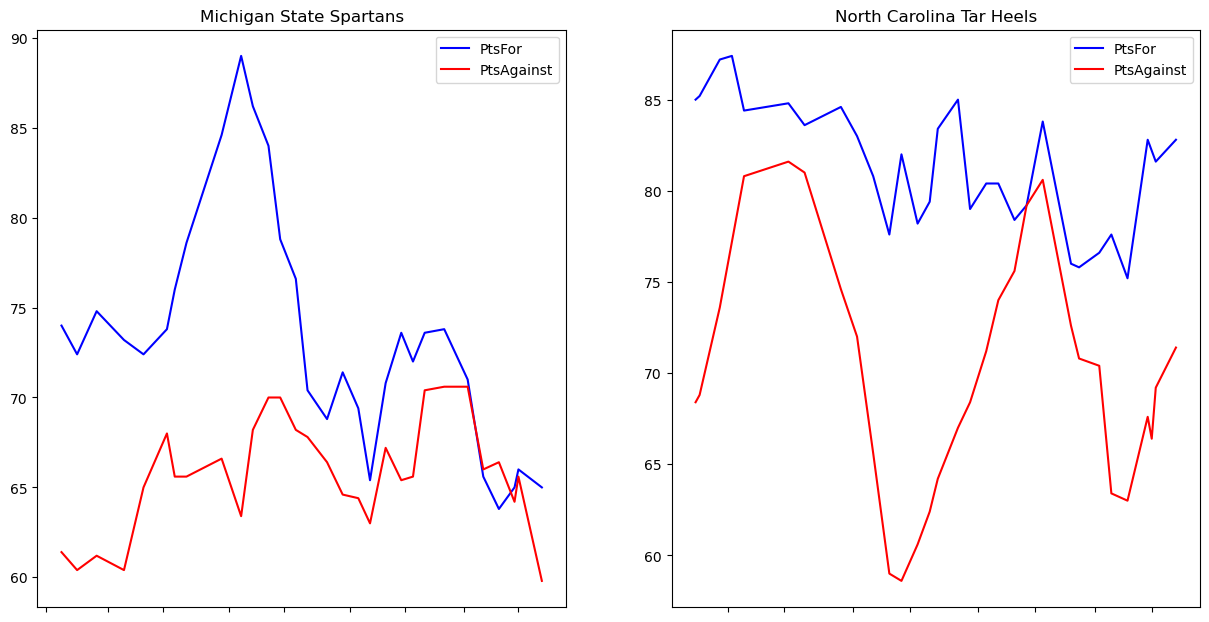

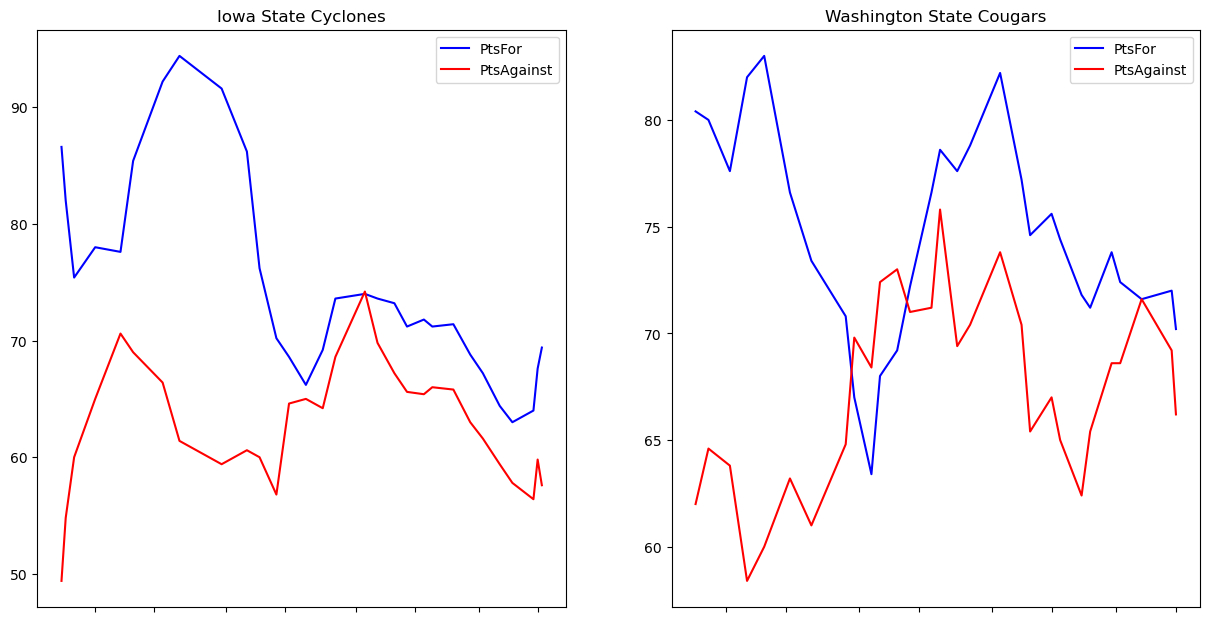

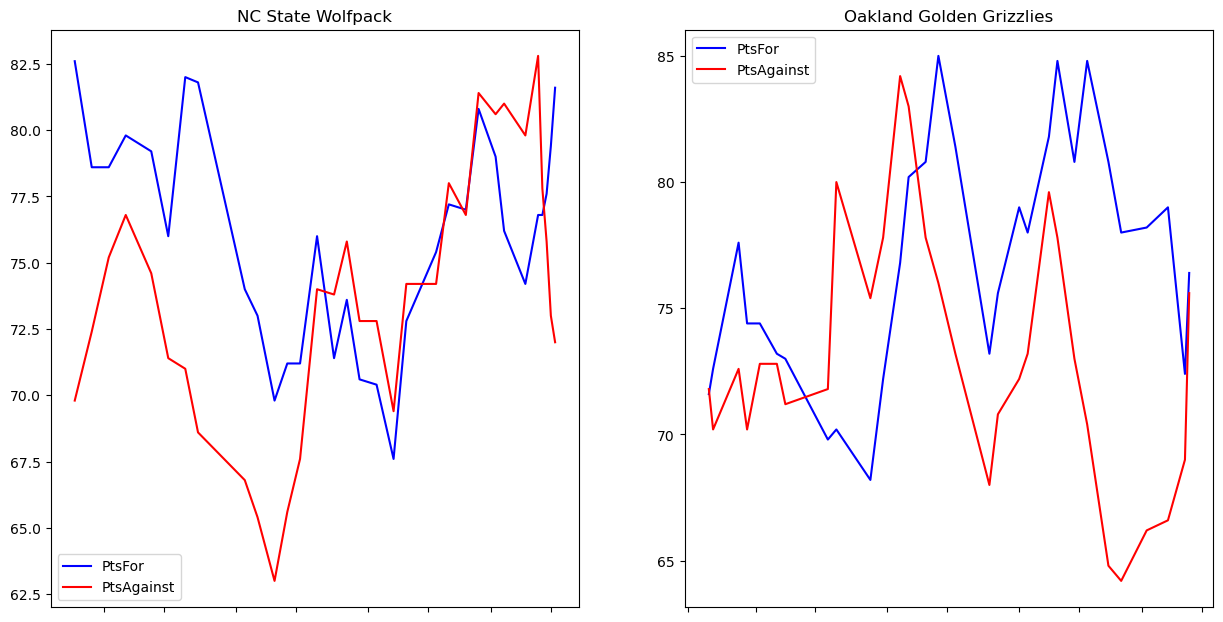

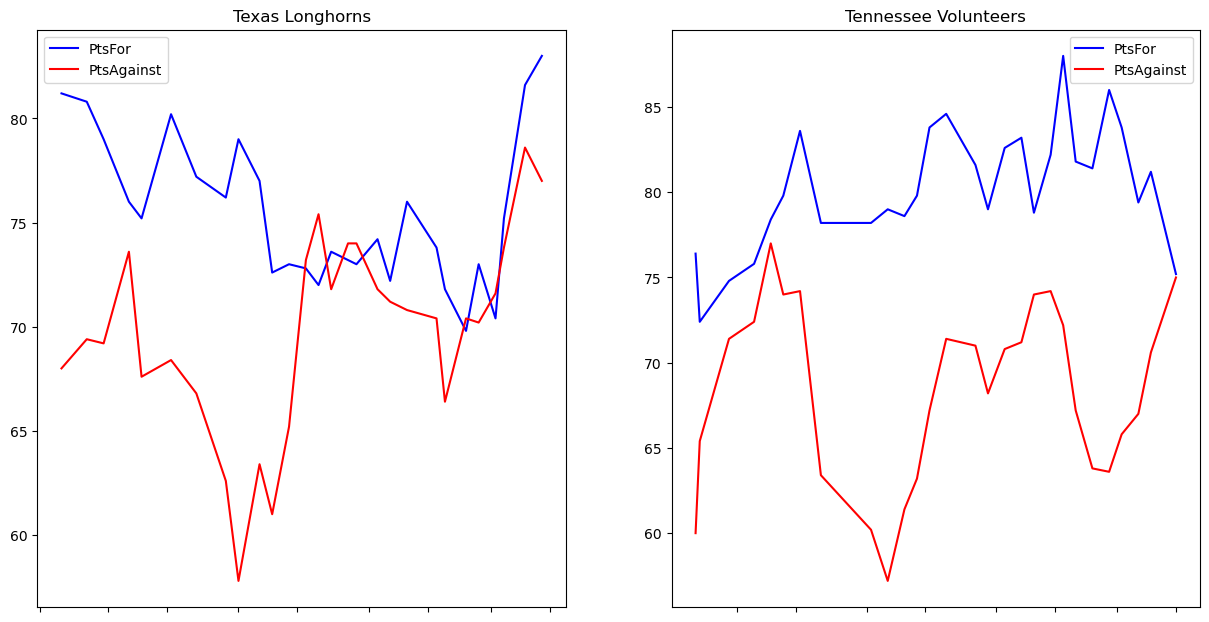

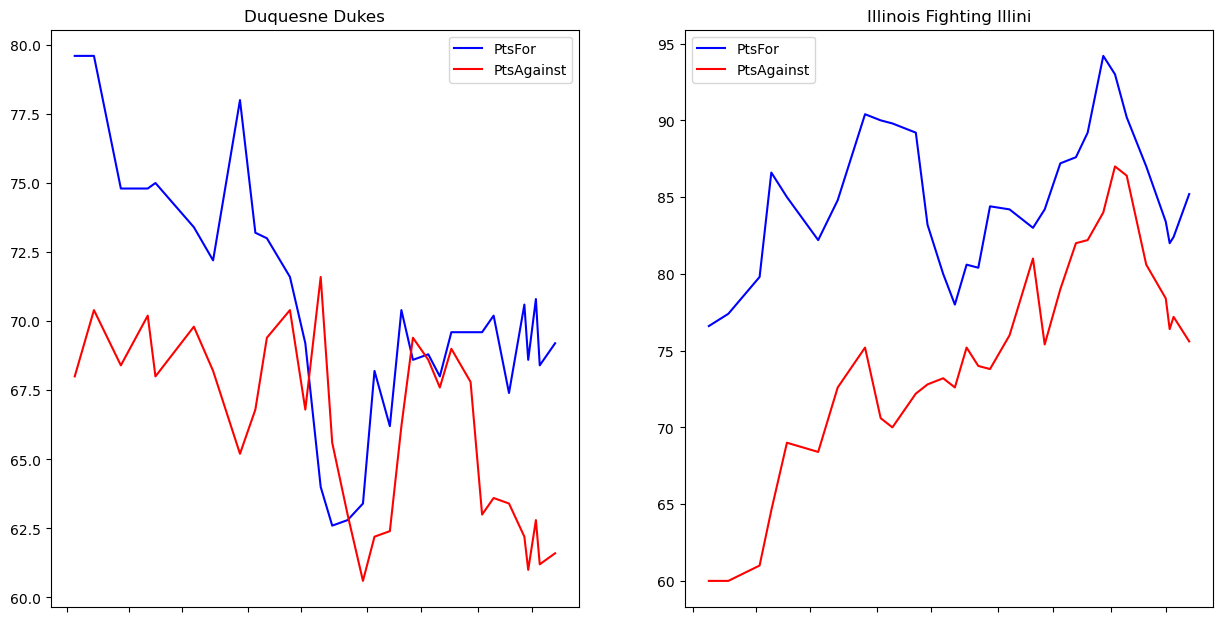

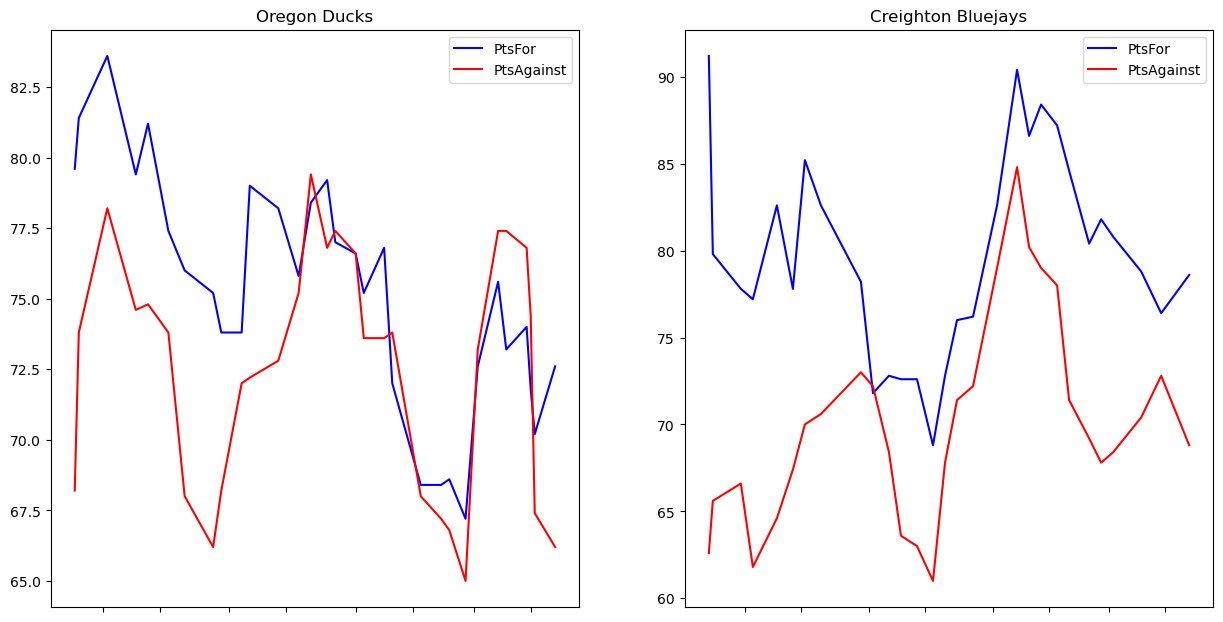

In [172]:
# plot time series of teams points for and against on the same axis for each tuple in the tst list
for d in tst:
    keys = d.keys()
    l = len(keys)
    fig, axes = plt.subplots(1, l, figsize=(15, 7.5))
    for i, (k, v) in enumerate(d.items()):
        df = v["team"]
        # smooth the PtsFor and PtsAgainst with 5 game rolling average
        smoothFor = df.PtsFor.rolling(5).mean()
        smoothAgainst = df.PtsAgainst.rolling(5).mean()
        idx = pd.to_datetime(df.game_day)
        axes[i].plot(idx, smoothFor, color='Blue', label="PtsFor")
        axes[i].plot(idx, smoothAgainst, color='Red', label="PtsAgainst")
        axes[i].set_title(k)
        axes[i].legend()
        # Set x ticks to be the months of the season

        axes[i].set_xticklabels(labels=[])
    tms = "_".join(keys)
    fname = f'{tms}_PtsFor_vs_PtsAgainst.png'
    fig.savefig(f"PtsRegressions/{fname}")

In [ ]:
clemson = get_team_games('Clemson Tigers')
newMexico = get_team_games('New Mexico Lobos')
alabama = get_team_games('Alabama Crimson Tide')
charleston = get_team_games('Charleston Cougars')
uab = get_team_games('UAB Blazers')
sdsu = get_team_games('San Diego State Aztecs')

In [ ]:
clemson["team"].head()

In [ ]:
nm = PtAdds(newMexico["team"], "New Mexico Lobos")

In [ ]:
nm.PtsAgainst.describe()

In [ ]:
clemson_tm = clemson["team"]
clemson_tm.PtsFor.describe()

In [ ]:
cW = np.where(clemson_tm.Spread > 0, "Black", "Red")
clemson_tm["TotalPt"] = clemson_tm["home_score"] + clemson_tm["away_score"]

In [ ]:
ffit = np.linalg.lstsq(np.vstack([clemson_tm.PtsFor, np.ones(len(clemson_tm.PtsFor))]).T, clemson_tm.TotalPt)
reg = ffit[0]

In [ ]:
ln = [x*reg[0] + reg[1] for x in clemson_tm.PtsFor]


In [ ]:
ax = plt.subplot()

ax.plot(clemson_tm.PtsFor, ln)
ax.scatter(x=clemson_tm.PtsFor, y=clemson_tm.TotalPt, 
           color=np.where(clemson_tm.Spread < -2.5, "Black", "Red"))

In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots()

# create a variable for a green/red colormap
cmap = plt.get_cmap('RdYlGn')

axes.scatter(x=clemson_Wins.PtsFor, y=clem_total, color=clem_line)
axes.plot(clemson_Wins.PtsFor, [clem_total.mean()]*len(clemson_Wins.PtsFor))

In [ ]:
tot = clemson_Wins.PtsFor + clemson_Wins.PtsAgainst
fit = np.linalg.lstsq(np.vstack([clemson_Wins.PtsFor,np.ones(len(clemson_Wins.PtsFor))]).T, tot, rcond=None)

In [ ]:
fit

In [ ]:
reg = [x*fit[0][0] + fit[0][1] for x in clemson_Wins.PtsFor]

In [ ]:
res = tot - reg

In [ ]:
ax = plt.subplot()

ax.scatter(x=clemson_Wins.PtsFor, y=res, color=clem_line)
ax.plot(clemson_Wins.PtsFor, [res.mean()]*21)

In [ ]:
stats.iqr(clemson["team"]["PtsFor"])

In [ ]:
df2.columns